In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../modules")
import PBD_analog
import matplotlib as mpl
plt.style.use("customstyle")
norm = mpl.colors.Normalize(vmin=0, vmax=1)

In [2]:
def mix_color(c1,c2,c3,u1,u2,u3, geom = True):
    if geom:# Geometric mean
        return np.power(c1**u1 * c2**u2 * c3**u3, 1/(u1+u2+u3))
    return (c1*u1 + c2*u2 + c3*u3)/(u1+u2+u3)

def plot_grad_line(ax, x0, y0, x1, y1, n_ticks = 5,                   
                   lsty = dict(ls = "-", color = "k"), 
                   revert_marker = False, ticksize = 3):

    X = np.linspace(x0, x1, n_ticks)
    Y = np.linspace(y0, y1, n_ticks)
    m = mpl.markers.MarkerStyle(3)
    angle = np.pi * float(revert_marker) + np.arctan((y1-y0) / (x1-x0))
    m._transform.rotate(angle)
    ax.plot(X, Y, marker = m, **lsty, markersize = ticksize)

def add_examples(ax, annot):
    ax.scatter(annot["x"], annot["y"], marker = "o", s = 190, color = "white")
    for xi, yi, ti in zip(annot["x"], annot["y"], annot["t"]):
        ax.text(xi, yi, ti, c = "k", ha = "center", va = "center_baseline", size = 12)

Let us consider a simplified case with 
$$b = \lambda_1 = \lambda_3$$
and
$$e = \mu_1 = \mu_2.$$

We can now consider the partial derivatives (chain rule):
\begin{align}
\frac{\partial \tilde\lambda}{\partial b}  &= \frac{\partial \tilde\lambda}{\partial \lambda_1}(b, \lambda_2, b, e, e) + \frac{\partial \tilde\lambda}{\partial \lambda_3}(b, \lambda_2, b, e, e) 
\end{align}

Since 
$$\frac{\partial \tilde\lambda}{\partial  \mu_1} = 0$$ 
we simply have 
$$\frac{\partial \tilde\lambda}{\partial  e} = \frac{\partial \tilde\lambda}{\partial \mu_2}$$


For the death rate we have simply
$$\frac{\partial \tilde\mu}{\partial  e} = 1 \quad \text{and} \quad \frac{\partial \tilde\mu}{\partial b} =  \frac{\partial \tilde\mu}{\partial \lambda_2}=  0 $$

In [3]:
def simp_birth(b, l2, e):
    return PBD_analog.analog_BD_rates(b, l2, b, e, e)[0]

def simp_death(b, l2, e):
    return PBD_analog.analog_BD_rates(b, l2, b, e, e)[1]

Text(0.5, 0.98, 'Influence of the PBD parameters on the BD equivalent constant rates')

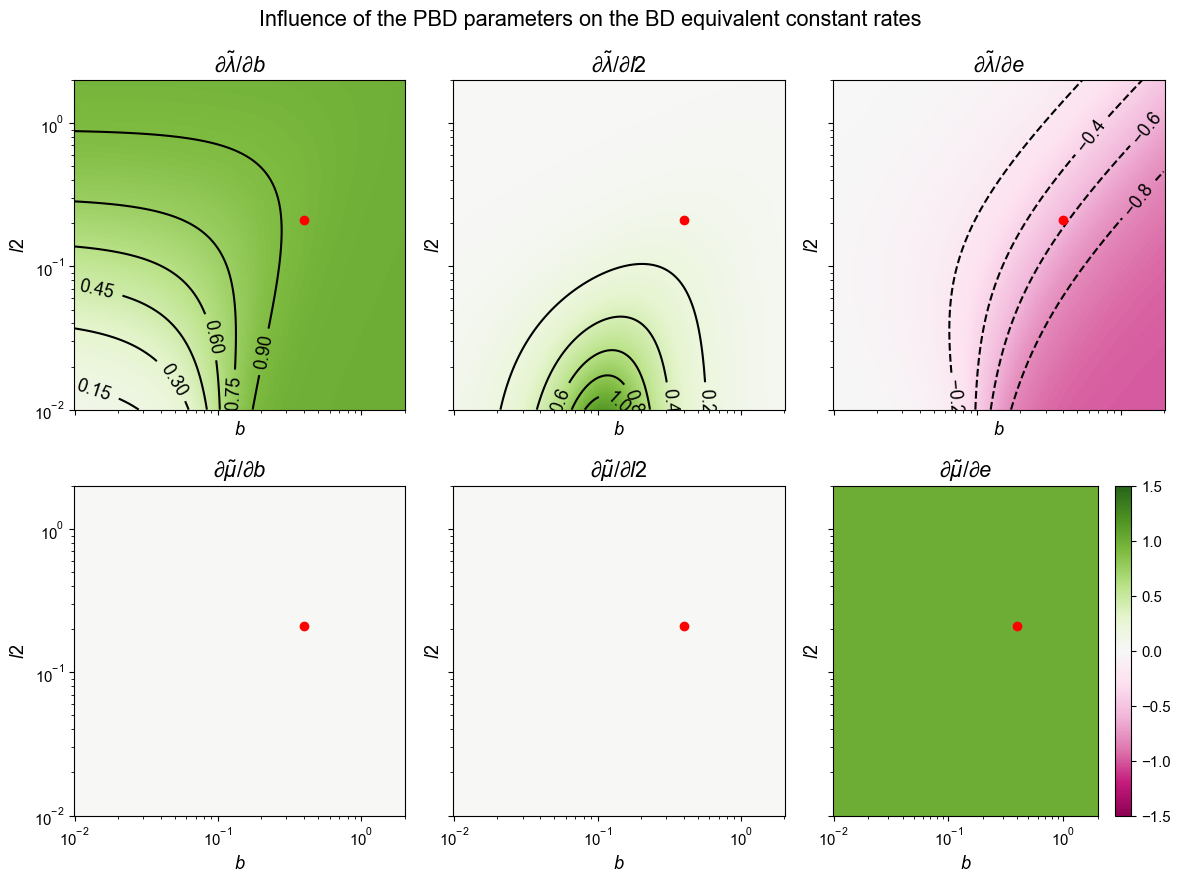

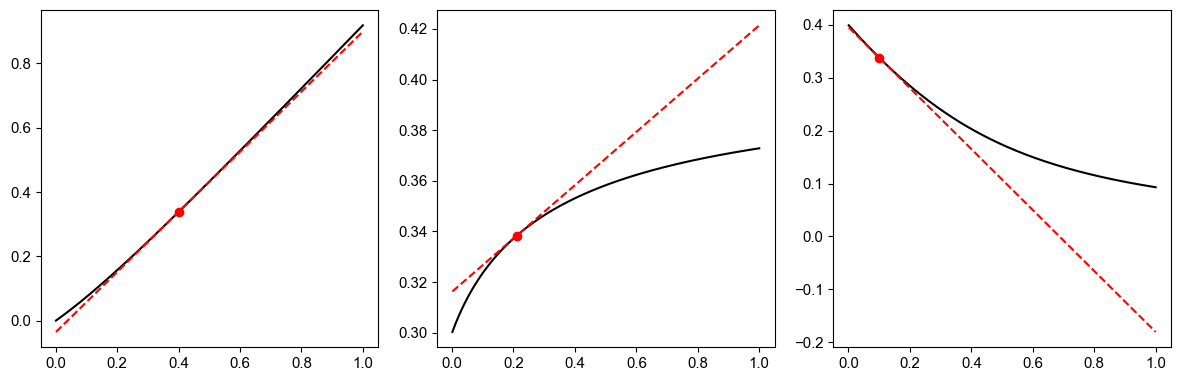

In [4]:
fig, axes = plt.subplots(2, 3,figsize = (12,9), sharex=True, sharey=True)
fig2, axes2 = plt.subplots(1, 3, figsize = (12,4))
bd_names = ["\\lambda", "\\mu"]
simp_pbd_names = ["b", "l2", "e"]

b = np.geomspace(0.01,2.0,200)
l2 = np.geomspace(0.01,2.0,400)
par = dict(e = 0.1)

example = (0.4, 0.21)
default = dict(b = example[0], l2 = example[1], **par)
y0 = simp_birth(*example, **par)
example_deriv = np.zeros((2, 3))
colormap = dict(cmap = "PiYG", vmin = -1.5, vmax = 1.5)

#levels = np.arange(0,1.6,0.1)


i_pbd = -1

for i_bd in (0,1):
    for i_simp_pbd in range(3):
        par_vary = simp_pbd_names[i_simp_pbd]
        ax = axes[i_bd, i_simp_pbd]
        
        ax.set_xscale("log")
        ax.set_yscale("log")
        
        Z = np.zeros((len(l2), len(b)))

        for i1 in range(len(b)):
            for i2 in range(len(l2)):
                Z[i2, i1] = PBD_analog.simp_jacobian_analog_bd(i_bd, i_simp_pbd, b = b[i1], l2 = l2[i2], **par)

        
        #cont = ax.contourf(l1, l2, Z, cmap = cmap, norm = norm, levels = levels)
        im = ax.pcolormesh(b, l2, Z, **colormap)
        cont = ax.contour(b, l2, Z, colors = "k", levels = 5)
        ax.clabel(cont, cont.levels)

        ax.plot([example[0]], [example[1]], ls = "", marker = "o", color = "red")
        example_deriv[i_bd, i_simp_pbd] = PBD_analog.simp_jacobian_analog_bd(i_bd, i_simp_pbd, b = example[0], l2 = example[1], **par)

        ax.set_title("$\\partial \\tilde{} / \\partial {}$".format(bd_names[i_bd], par_vary))
        ax.set_xlabel("${}$".format(simp_pbd_names[0]))
        ax.set_ylabel("${}$".format(simp_pbd_names[1]))

        # Plot actual dynamics 
        if i_bd == 0:
            x = np.linspace(0.001, 1.0, 200)
            param = default.copy()
            x0 = default[par_vary]
            param[par_vary] = x
            y = simp_birth(**param)

            axes2[i_simp_pbd].plot(x,y)
            axes2[i_simp_pbd].plot([x0], [y0], ls = "", marker = "o", color = "red")

            axes2[i_simp_pbd].plot(x, y0 + example_deriv[0, i_simp_pbd]*(x-x0), ls = "--", color = "red")


fig.colorbar(im)
fig.suptitle("Influence of the PBD parameters on the BD equivalent constant rates")

In [5]:
b = np.geomspace(0.01,1.0,200)
l2 = np.geomspace(0.005,1.0,200)
par = dict(e = 0.1)


varJacbl2 = np.zeros((2, 3, len(l2), len(b)))

for i_bd in (0,1):
    for i_simp_pbd in range(3):
        Z = np.zeros((len(l2), len(b)))
        F = np.zeros_like(Z)
        for i1 in range(len(b)):
            for i2 in range(len(l2)):
                Z[i2, i1] = PBD_analog.simp_jacobian_analog_bd(i_bd, i_simp_pbd, b = b[i1], l2 = l2[i2], **par)
                varJacbl2[i_bd, i_simp_pbd, i2, i1] = Z[i2, i1]


e = np.geomspace(0.005,1.0,200)
par = dict(b = 0.1)
varJacel2 = np.zeros((2, 3, len(l2), len(e)))

for i_bd in (0,1):
    for i_simp_pbd in range(3):
        Z = np.zeros((len(l2), len(e)))
        F = np.zeros_like(Z)
        for i1 in range(len(e)):
            for i2 in range(len(l2)):
                Z[i2, i1] = PBD_analog.simp_jacobian_analog_bd(i_bd, i_simp_pbd, e = e[i1], l2 = l2[i2], **par)
                varJacel2[i_bd, i_simp_pbd, i2, i1] = Z[i2, i1]


# relative values of the partial derivatives 
sumJac = np.sum(np.abs(varJacbl2), axis = 1)
relatJacbl2 = np.zeros_like(varJacbl2)
for i_simp_pbd in range(3):
    relatJacbl2[:, i_simp_pbd, :, :] = varJacbl2[:, i_simp_pbd, :, :] / sumJac
relatJacbl2 = 100 * relatJacbl2
sumJac = np.sum(np.abs(varJacel2), axis = 1)
relatJacel2 = np.zeros_like(varJacel2)
for i_simp_pbd in range(3):
    relatJacel2[:, i_simp_pbd, :, :] = varJacel2[:, i_simp_pbd, :, :] / sumJac
relatJacel2 = 100 * relatJacel2

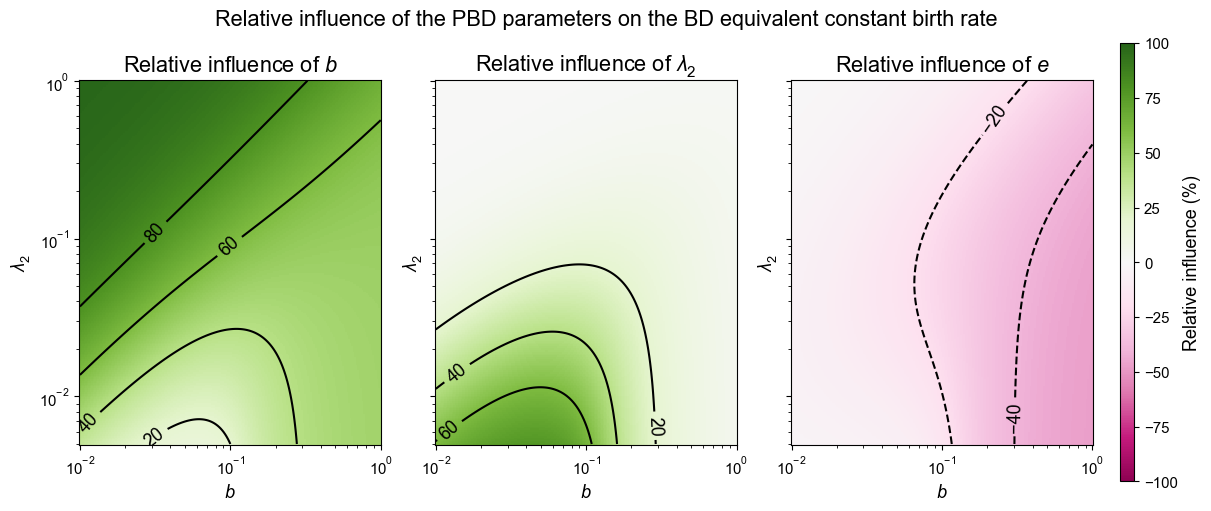

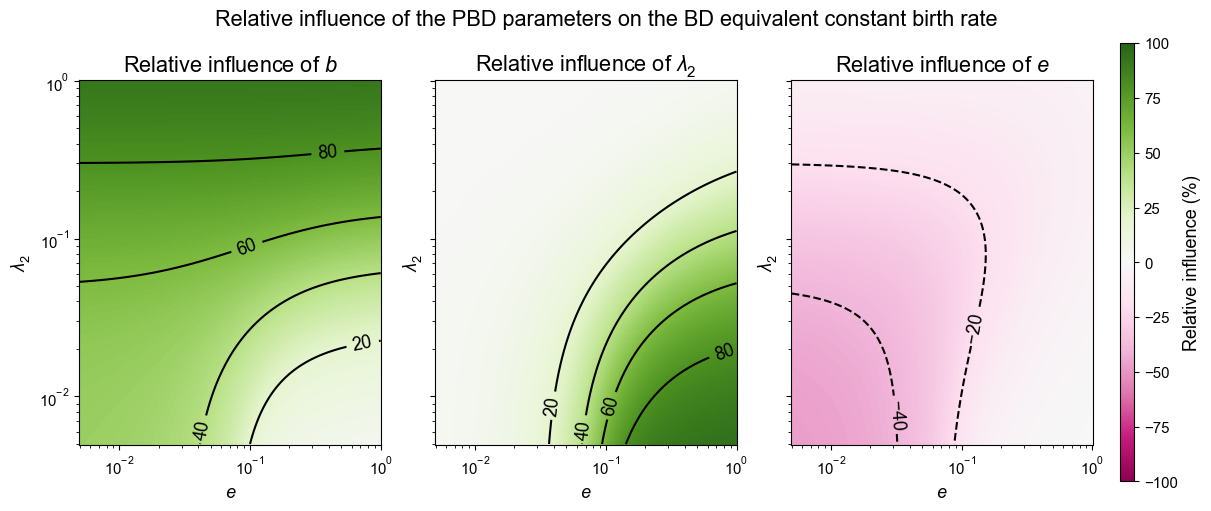

In [6]:
fig, axes = plt.subplots(1, 3,figsize = (12,5), sharex=True, sharey=True, layout = "constrained")

simp_pbd_full_names = ["b", "\\lambda_2", "e"]

colormap = dict(cmap = "PiYG", vmin = -100, vmax = 100)
levels = np.linspace(-100, 100, 11)

for i in range(3):
    ax = axes[i]
    ax.set_xscale("log")
    ax.set_yscale("log")
    im = ax.pcolormesh(b, l2, relatJacbl2[0, i, :, :], **colormap)
    cont = ax.contour(b, l2, relatJacbl2[0, i, :, :], colors = "k", levels = levels)
    ax.clabel(cont, cont.levels)
    

    ax.set_title("Relative influence of ${}$".format(simp_pbd_full_names[i]))
    ax.set_xlabel("$b$")
    ax.set_ylabel("$\\lambda_2$")
    

fig.colorbar(im, label = "Relative influence (%)", shrink = 1.2, aspect = 30)
fig.suptitle("Relative influence of the PBD parameters on the BD equivalent constant birth rate")

plt.savefig("../fig/SM_relative_influence_bl2.pdf")
plt.savefig("../fig/SM_relative_influence_bl2.png")

fig, axes = plt.subplots(1, 3,figsize = (12,5), sharex=True, sharey=True, layout = "constrained")
colormap = dict(cmap = "PiYG", vmin = -100, vmax = 100)
levels = np.linspace(-100, 100, 11)

for i in range(3):
    ax = axes[i]
    ax.set_xscale("log")
    ax.set_yscale("log")
    im = ax.pcolormesh(e, l2, relatJacel2[0, i, :, :], **colormap)
    cont = ax.contour(e, l2, relatJacel2[0, i, :, :], colors = "k", levels = levels)
    ax.clabel(cont, cont.levels)
    
    
    ax.set_title("Relative influence of ${}$".format(simp_pbd_full_names[i]))
    ax.set_xlabel("$e$")
    ax.set_ylabel("$\\lambda_2$")
    

fig.colorbar(im, label = "Relative influence (%)", shrink = 1.2, aspect = 30)
fig.suptitle("Relative influence of the PBD parameters on the BD equivalent constant birth rate")

plt.savefig("../fig/SM_relative_influence_el2.pdf")
plt.savefig("../fig/SM_relative_influence_el2.png")

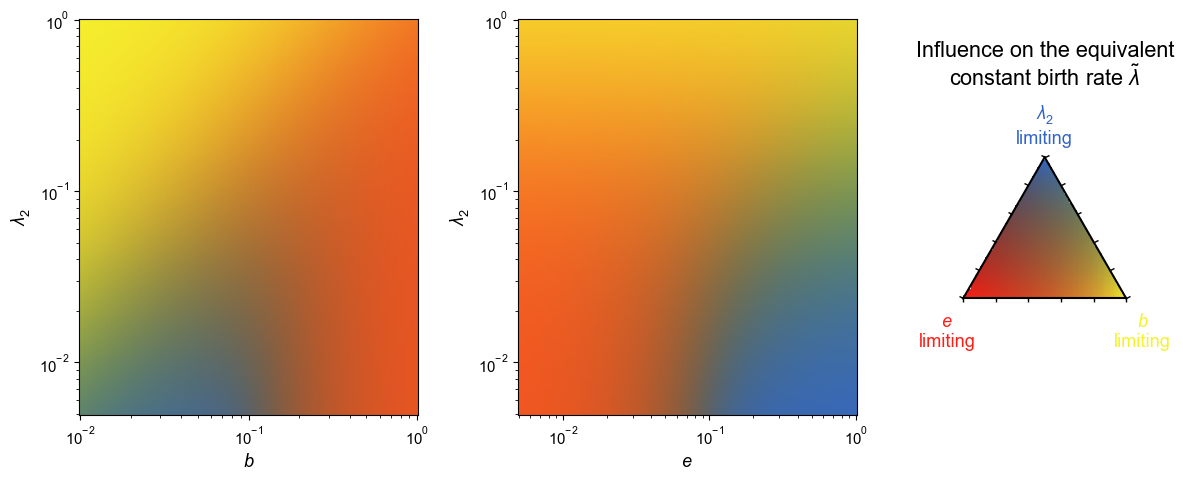

In [8]:
# Mix color matrix
col_l2 = np.array([51,100,200], dtype = float) / 255
col_b = np.array([245,242,45], dtype = float) / 255
col_e = np.array([255,29,21], dtype = float) / 255

geom = True

#annotbl2 = dict(x = [0.03, 0.8, 0.4],
#                 y = [0.4, 0.2, 0.01], 
#                 t = ['1','4','5'])
#annotel2 = dict(x = [0.3, 0.009, 0.05], 
#                 y = [0.01, 0.017, 0.78], 
#                 t = ['3', '6', '2'])
# b vs l2
sumJacbl2 = np.sum(np.abs(varJacbl2[0, :, :, :]), axis = 0)
colMatbl2 = np.zeros((len(l2), len(b), 3))
for i_hue in range(3):
    colMatbl2[:, :, i_hue] = mix_color(col_b[i_hue], col_l2[i_hue], col_e[i_hue],
                                        np.abs(varJacbl2[0, 0, :, :]) / sumJacbl2,
                                        np.abs(varJacbl2[0, 1, :, :]) / sumJacbl2,
                                        np.abs(varJacbl2[0, 2, :, :]) / sumJacbl2,
                                        geom=geom)


# m2 vs l2
sumJacel2 = np.sum(np.abs(varJacel2[0, :, :, :]), axis = 0)
colMatel2 = np.zeros((len(l2), len(e), 3))
for i_hue in range(3):
    colMatel2[:, :, i_hue] = mix_color(col_b[i_hue], col_l2[i_hue], col_e[i_hue],
                                        np.abs(varJacel2[0, 0, :, :]) / sumJacel2,
                                        np.abs(varJacel2[0, 1, :, :]) / sumJacel2,
                                        np.abs(varJacel2[0, 2, :, :]) / sumJacel2,
                                        geom=geom)

fig, axes = plt.subplots(1,3, figsize = (12, 5), width_ratios=(2.5,2.5,1.3))
ax = axes[0]
ax.set_xscale("log")
ax.set_yscale("log")
ax.pcolormesh(b, l2, colMatbl2, antialiased = True)

ax.set_xlabel("$b$")
ax.set_ylabel("$\\lambda_2$")

ax = axes[1]
ax.set_xscale("log")
ax.set_yscale("log")
ax.pcolormesh(e, l2, colMatel2)

ax.set_xlabel("$e$")
ax.set_ylabel("$\\lambda_2$")


# Add annotations
#add_examples(axes[0], annotbl2)
#add_examples(axes[1], annotel2)
#axes[0].text(x = 0.02, y = 0.92, s = 'A', weight = "bold", 
#             size = "x-large", transform = axes[0].transAxes)
#axes[1].text(x = 0.02, y = 0.92, s = 'B', weight = "bold", 
#             size = "x-large", transform = axes[1].transAxes)

# Triangle caption
ax = axes[2]
ax.axis("off")
xtri, ytri = 0.5, np.sqrt(0.75) # coordinates triangle

x = np.linspace(-xtri-0.25, xtri + 0.25, 100)
y = np.linspace(-0.25, ytri + 0.25, 100)



captionmat = np.ones((len(y), len(x), 3))


def color_by_distance(xx, yy):
    d1 = 1-np.sqrt((xx - xtri)**2 + yy**2)
    d2 = 1-np.sqrt(xx**2 + (yy - ytri)**2)
    d3 = 1-np.sqrt((xx+xtri)**2 + yy**2)
    return mix_color(col_b, col_l2, col_e, d1, d2, d3, geom = geom)

for j in range(len(y)):
    yy = y[j]
    if yy>0 and yy <= 1:
        for i in range(len(x)):
            xx = x[i]
            if yy <= ytri - np.abs(xx)*ytri/xtri:
                captionmat[j,i,:] = color_by_distance(xx, yy)

ax.pcolormesh(x, y, captionmat)
ticklabels = ['', '20', '40', '60', '80', '']
plot_grad_line(ax, -xtri, 0, xtri, 0, 6)
plot_grad_line(ax, -xtri, 0, 0, ytri, 6, revert_marker=True)
plot_grad_line(ax, xtri, 0, 0, ytri, 6, revert_marker=True)

ax.text(x = 0.6, y = -0.3, s = "$b$\nlimiting", ha = 'center', color = col_b)
ax.text(x = 0, y = 0.95, s = "$\\lambda_2$\nlimiting", ha = 'center', color = col_l2)
ax.text(x = -0.6, y = -0.3, s = "$e$\nlimiting", ha = 'center', color = col_e)

ax.set_aspect("equal", adjustable="box")
ax.tick_params(axis='y', which='major', pad=-15)

ax.set_xlim(-0.54,0.54)
ax.set_ylim(-0.25, 1.25)
ax.set_ylabel(None)
ax.set_title("Influence on the equivalent\nconstant birth rate $\\tilde\\lambda$")
plt.savefig("../fig/simp_influence_parameters.pdf")
plt.savefig("../fig/simp_influence_parameters.png")